### This jupyter notebooks provides the code for classifying signals using the Discrete Cosine Transform (type-2).
### To get some more background information, please have a look at the accompanying blog-post:
### http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import os
from time import perf_counter
import numpy as np
from scipy.fftpack import dct

import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import keras
from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
history = History()

# 1. Loading the UCI HAR dataset
download dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../datasets/UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


# 2. Generating features for the UCI-HAR features

In [3]:
def get_uci_har_dct_features(dataset, labels, truncated_len=None):
    uci_har_features = []
    # Take the DWT of each component and concat them end-to-end
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            coeff = dct(signal)[:truncated_len]
            features.append(list(coeff))
        uci_har_features.append(features)
    print(np.shape(uci_har_features))
    X = np.array(uci_har_features).transpose(0,2,1)
    Y = labels
    return X, Y

In [4]:
truncate_len = 128

t_start = perf_counter()
x_train, y_train = get_uci_har_dct_features(uci_har_signals_train, uci_har_labels_train, \
                                        truncated_len=truncate_len)
x_test, y_test = get_uci_har_dct_features(uci_har_signals_test, uci_har_labels_test, \
                                      truncated_len=truncate_len)
t_stop = perf_counter()
t_diff = t_stop-t_start
print ('Time for DCT preprocessing {} seconds'.format(t_diff))
print ('Training data shape: {}'.format(x_train.shape))
print ('Test data shape: {}'.format(x_test.shape))

(7352, 9, 128)
(2947, 9, 128)
Time for DCT preprocessing 8.428480695999998 seconds
Training data shape: (7352, 128, 9)
Test data shape: (2947, 128, 9)


# 3. Classifying the train and test sets

In [5]:
num_classes = 6

batch_size = 8
epochs = 128

input_shape = np.shape(x_train)[1:]
print('input_shape: {}'.format(input_shape))

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = list(y_train)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = list(y_test)
y_test = keras.utils.to_categorical(y_test, num_classes)

input_shape: (128, 9)
x_train shape: (7352, 128, 9)
7352 train samples
2947 test samples


In [6]:
model = Sequential()

normalizer = preprocessing.Normalization()
normalizer.adapt(x_train)

model.add(keras.Input(shape=input_shape))
model.add(normalizer)
model.add(Conv1D(16, kernel_size=3, strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv1D(32, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(96, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5,l2=1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5),\
                activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=0, patience=8)
t_start = perf_counter()
model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[history,es])
t_stop = perf_counter()
t_diff = t_stop-t_start
print ('Time to train the network {} seconds'.format(t_diff))

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 128, 9)            19        
_________________________________________________________________
conv1d (Conv1D)              (None, 63, 16)            448       
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 16)            64        
_________________________________________________________________
activation (Activation)      (None, 63, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 61, 32)            1568      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 32)            128       
_________________________________________________________________
activation_1 (Activation)    (None, 61, 32)            0

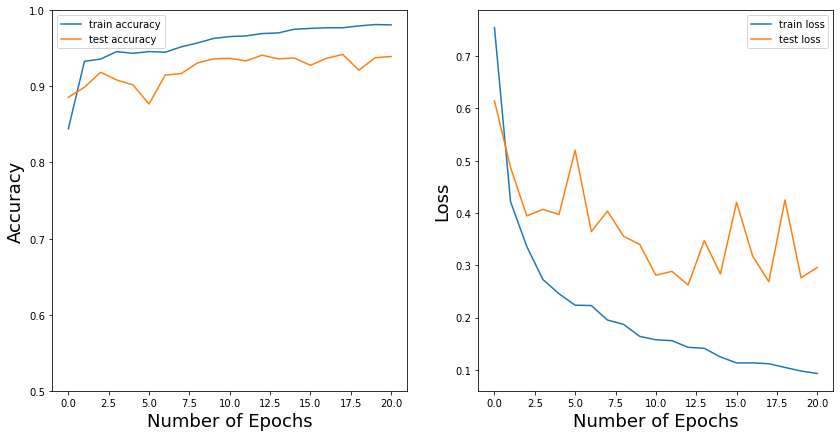

In [7]:
fig, axarr = plt.subplots(figsize=(14,7), ncols=2)
axarr[0].plot(history.history['accuracy'], label='train accuracy')
axarr[0].plot(history.history['val_accuracy'], label='test accuracy')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0.5,1])
axarr[0].legend()

axarr[1].plot(history.history['loss'], label='train loss')
axarr[1].plot(history.history['val_loss'], label='test loss')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Loss', fontsize=18)
axarr[1].legend()

plt.show()